In [195]:
# importing packages
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# sklearn packages
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import xgboost as xgb

# nltk packages
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
nltk.download('punkt')
from string import punctuation
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [196]:
data = pd.read_csv('engData.csv', sep='\t', encoding='utf-8',index_col=0) 
data.head()

,sentence,tag
0,I was in the mountains.,0
1,I never liked biology.,0
2,I didn't like it.,0
3,That wasn't my intention.,0
4,One million people lost their lives in the war.,0


In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10649 entries, 0 to 10648
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  10649 non-null  object
 1   tag       10649 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 249.6+ KB


In [198]:
data['sentence'] = data['sentence'].str.lower()


In [199]:
def unidecode_text(text):
    try:
        #pdb.set_trace()
        text = unidecode.unidecode(text)
    except:
        pass
    return text

In [200]:
data['sentence'] = data.apply(lambda row: unidecode_text(row['sentence']), axis=1)

In [201]:
data.head()

,sentence,tag
0,i was in the mountains.,0
1,i never liked biology.,0
2,i didn't like it.,0
3,that wasn't my intention.,0
4,one million people lost their lives in the war.,0


In [202]:

defTags = ['NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJS', 'JJR']#, 'RB', 'RBS', 'RBR', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

# functions to determine the type of a word
def is_noun(tag):
    return tag in ['NN', 'NNS', 'NNP', 'NNPS']


def is_verb(tag):
    return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']


def is_adverb(tag):
    return tag in ['RB', 'RBR', 'RBS']


def is_adjective(tag):
    return tag in ['JJ', 'JJR', 'JJS']

# transform tag forms
def penn_to_wn(tag):
    if is_adjective(tag):
        return nltk.stem.wordnet.wordnet.ADJ
    elif is_noun(tag):
        return nltk.stem.wordnet.wordnet.NOUN
    elif is_adverb(tag):
        return nltk.stem.wordnet.wordnet.ADV
    elif is_verb(tag):
        return nltk.stem.wordnet.wordnet.VERB
    return nltk.stem.wordnet.wordnet.NOUN

    # lemmatizer + tokenizer (+ stemming) class
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        # we define (but not use) a stemming method, uncomment the last line in __call__ to get stemming tooo
        self.stemmer = nltk.stem.SnowballStemmer('english') 
    def __call__(self, doc):
        # pattern for numbers | words of length=2 | punctuations | words of length=1
        pattern = re.compile(r'[0-9]+|\b[\w]{2,2}\b|[%.,_`!"&?\')({~@;:#}+-]+|\b[\w]{1,1}\b')
        # tokenize document
        doc_tok = word_tokenize(doc)
        #filter out patterns from words
        # doc_tok = [x for x in doc_tok if x not in stop_words1]
        doc_tok = [pattern.sub('', x) for x in doc_tok]
        # get rid of anything with length=1
        doc_tok = [x for x in doc_tok if len(x) > 1]
        # position tagging
        doc_tagged = nltk.pos_tag(doc_tok)
        # selecting nouns and adjectives
        doc_tagged = [(t[0], t[1]) for t in doc_tagged if t[1] in defTags]
        # preparing lemmatization
        doc = [(t[0], penn_to_wn(t[1])) for t in doc_tagged]
        # lemmatization
        doc = [self.wnl.lemmatize(t[0], t[1]) for t in doc]
        # uncomment if you want stemming as well
        #doc = [self.stemmer.stem(x) for x in doc]
        return doc

In [203]:
vec_tdidf = TfidfVectorizer(ngram_range=(1,1), analyzer='word', norm='l2', tokenizer=LemmaTokenizer())

In [204]:
from sklearn.base import BaseEstimator, TransformerMixin
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None, *parg, **kwarg):
        return self

    def transform(self, X):
        # returns the input as a string
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # returns the input as a dataframe
        return X[[self.key]]

In [205]:
from sklearn.pipeline import Pipeline, FeatureUnion
text = Pipeline([
                ('selector', TextSelector(key='sentence')),
                ('vectorizer', vec_tdidf)
                ])

In [206]:
clf = xgb.XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)

In [207]:
pipe = Pipeline([('feats', text),
                 ('clf',clf)
                 ])

In [208]:
pipe.named_steps['clf'].get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.6,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 2,
 'silent': None,
 'subsample': 0.7,
 'verbosity': 1}

In [209]:
X = data.iloc[:, :1]
Y = data.iloc[:, 1:]
X

,sentence
0,i was in the mountains.
1,i never liked biology.
2,i didn't like it.
3,that wasn't my intention.
4,one million people lost their lives in the war.
...,...
10644,all i want is you.
10645,don't hesitate to ask if you want anything.
10646,take anything you want.
10647,don't confuse desire with love.


In [210]:
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.3, stratify=Y, random_state=0)

In [211]:
param_grid = {
     'clf__n_estimators': [50,100,300]}

In [212]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator = pipe, param_grid = param_grid, 
                          cv = 3, n_jobs = 1, verbose = 0, return_train_score=True)

In [213]:
grid_search.fit(train_X, train_y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('feats',
                                        Pipeline(memory=None,
                                                 steps=[('selector',
                                                         TextSelector(key='sentence')),
                                                        ('vectorizer',
                                                         TfidfVectorizer(analyzer='word',
                                                                         binary=False,
                                                                         decode_error='strict',
                                                                         dtype=<class 'numpy.float64'>,
                                                                         encoding='utf-8',
                                                                         input='content',
                      

In [214]:
grid_search.cv_results_['mean_train_score']

array([0.6487792 , 0.65676157, 0.6760799 ])

In [215]:
grid_search.cv_results_['mean_test_score']

array([0.64596095, 0.64958257, 0.65441306])

In [216]:
grid_search.best_params_

{'clf__n_estimators': 300}

In [217]:
clf_test = grid_search.best_estimator_

In [218]:
preds = clf_test.predict(test_X)

In [219]:
def print_stats(preds, target, labels, sep='-', sep_len=40, fig_size=(10,8)):
    print('Accuracy = %.3f' % metrics.accuracy_score(target, preds))
    print(sep*sep_len)
    print('Classification report:')
    print(metrics.classification_report(target, preds))
    print(sep*sep_len)
    print('Confusion matrix')
    cm=metrics.confusion_matrix(target, preds)
    cm = cm / np.sum(cm, axis=1)[:,None]
    sns.set(rc={'figure.figsize':fig_size})
    sns.heatmap(cm, 
        xticklabels=labels,
        yticklabels=labels,
           annot=True, cmap = 'YlGnBu')
    plt.pause(0.05)

Accuracy = 0.666
----------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.41      0.91      0.57       769
           1       0.95      0.59      0.73      2426

    accuracy                           0.67      3195
   macro avg       0.68      0.75      0.65      3195
weighted avg       0.82      0.67      0.69      3195

----------------------------------------
Confusion matrix


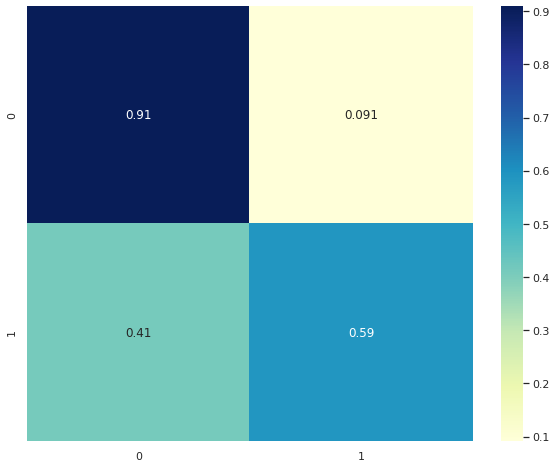

In [220]:
print_stats(test_y, preds, clf_test.classes_)

In [221]:
headers = list(test_X)
input_variable = pd.DataFrame(["I understand you."],
                                columns=headers, 
                                dtype=object,
                                index=['input'])
prediction = clf_test.predict(input_variable)
print("Prediction: ", prediction)

Prediction:  [1]
